## Bibliotecas

In [1]:
import sys
sys.path.append('..\\..\\..\\')

In [2]:
## Spark SQL
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

# Spark ML
from src.hermione_spark.data_source import SparkSpreadsheet, SparkCleaner
from src.hermione_spark.preprocessing import SparkPreprocessor, SparkScaler, SparkVectorizer
from src.hermione_spark.model import *
from src.hermione_spark.analysis import SparkPCA, SparkCluster, SparkFS

In [3]:
import mlflow.pyspark.ml

In [4]:
spark = (
    SparkSession
    .builder
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
    .config("spark.driver.memory", "6g")
    .getOrCreate()
)

## Reading Data

In [5]:
ss_source = Spreadsheet(spark)

In [6]:
df_train = ss_source.get_data('../../../data/raw/raw_train', 'parquet')
df_test = ss_source.get_data('../../../data/raw/raw_test', 'parquet', )

In [7]:
df_train.limit(5).toPandas()

,Survived,Pclass,Sex,Age
0,1,2,female,34.0
1,1,2,female,31.0
2,1,1,male,36.0
3,1,3,male,29.0
4,0,2,male,18.0


In [8]:
df_train.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)



## Cleaning Data

In [9]:
cleaner = SparkCleaner(spark)

In [10]:
cleaner.clean()

In [11]:
ss_source.get_data('teste', 'parquet').limit(5).toPandas()

,Survived,Pclass,Sex,Age
0,1,2,Female,34
1,1,2,Female,31
2,1,1,Male,36
3,1,3,Male,29
4,0,2,Male,18


In [12]:
ss_source.get_data('teste', 'parquet').printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)



## Preprocessing

### Scaling

In [13]:
scaler = SparkScaler({'min_max': 'Age',})

In [14]:
scaler.fit(df_train)

<class 'src.ml.preprocessing.normalization.SparkScaler'>

In [15]:
scaler.transform(df_train).toPandas()

,Survived,Pclass,Sex,Age,min_max_scaled
0,1,2,female,34.0,[0.4219653179190751]
1,1,2,female,31.0,[0.38426740387031916]
2,1,1,male,36.0,[0.4470972606182458]
3,1,3,male,29.0,[0.35913546117114853]
4,0,2,male,18.0,[0.22090977632570996]
...,...,...,...,...,...
487,1,2,female,34.0,[0.4219653179190751]
488,1,2,female,30.0,[0.37170143252073384]
489,0,3,male,32.0,[0.39683337521990447]
490,0,3,male,30.0,[0.37170143252073384]


In [16]:
scaler = SparkScaler({'min_max': 'Age', 'zscore': 'Age'})
scaler.fit_transform(df_train).toPandas()

,Survived,Pclass,Sex,Age,min_max_scaled,zscore_scaled
0,1,2,female,34.0,[0.4219653179190751],[0.2873779211086445]
1,1,2,female,31.0,[0.38426740387031916],[0.0778327033694635]
2,1,1,male,36.0,[0.4470972606182458],[0.4270747329347652]
3,1,3,male,29.0,[0.35913546117114853],[-0.06186410845665717]
4,0,2,male,18.0,[0.22090977632570996],[-0.8301965735003208]
...,...,...,...,...,...,...
487,1,2,female,34.0,[0.4219653179190751],[0.2873779211086445]
488,1,2,female,30.0,[0.37170143252073384],[0.007984297456403168]
489,0,3,male,32.0,[0.39683337521990447],[0.14768110928252384]
490,0,3,male,30.0,[0.37170143252073384],[0.007984297456403168]


### Preprocessing

In [23]:
processor = SparkPreprocessor({'zscore': 'Age'}, ['Pclass', 'Sex'], impute_strategy = 'mean')

In [24]:
processor.fit(df_train)

<class 'src.ml.preprocessing.preprocessing.SparkPreprocessor'>

In [25]:
processor.transform(df_train).toPandas()

,Survived,Pclass,Sex,Age,Pclass_ohe,Sex_ohe,zscore_scaled,features
0,1,2,female,34.0,"(0.0, 0.0, 1.0)","(0.0, 1.0)",[0.323450513578003],"[0.0, 0.0, 1.0, 0.0, 1.0, 0.323450513578003]"
1,1,2,female,31.0,"(0.0, 0.0, 1.0)","(0.0, 1.0)",[0.08760251233253245],"[0.0, 0.0, 1.0, 0.0, 1.0, 0.08760251233253245]"
2,1,1,male,36.0,"(0.0, 1.0, 0.0)","(1.0, 0.0)",[0.48068251440831666],"[0.0, 1.0, 0.0, 1.0, 0.0, 0.48068251440831666]"
3,1,3,male,29.0,"(1.0, 0.0, 0.0)","(1.0, 0.0)",[-0.06962948849778124],"[1.0, 0.0, 0.0, 1.0, 0.0, -0.06962948849778124]"
4,0,2,male,18.0,"(0.0, 0.0, 1.0)","(1.0, 0.0)",[-0.9344054930645065],"[0.0, 0.0, 1.0, 1.0, 0.0, -0.9344054930645065]"
...,...,...,...,...,...,...,...,...
618,1,2,female,34.0,"(0.0, 0.0, 1.0)","(0.0, 1.0)",[0.323450513578003],"[0.0, 0.0, 1.0, 0.0, 1.0, 0.323450513578003]"
619,1,2,female,30.0,"(0.0, 0.0, 1.0)","(0.0, 1.0)",[0.008986511917375603],"[0.0, 0.0, 1.0, 0.0, 1.0, 0.008986511917375603]"
620,0,3,male,32.0,"(1.0, 0.0, 0.0)","(1.0, 0.0)",[0.16621851274768928],"[1.0, 0.0, 0.0, 1.0, 0.0, 0.16621851274768928]"
621,0,3,male,30.0,"(1.0, 0.0, 0.0)","(1.0, 0.0)",[0.008986511917375603],"[1.0, 0.0, 0.0, 1.0, 0.0, 0.008986511917375603]"


In [20]:
processor = SparkPreprocessor({'zscore': 'Age', 'min_max': 'Age'}, ['Pclass', 'Sex'], impute_strategy = 'mode')
processor.fit_transform(df_train).toPandas()

,Survived,Pclass,Sex,Age,Pclass_ohe,Sex_ohe,zscore_scaled,min_max_scaled,features
0,1,2,female,34.0,"(0.0, 0.0, 1.0)","(0.0, 1.0)",[0.43996324874400106],[0.4219653179190751],"[0.0, 0.0, 1.0, 0.0, 1.0, 0.43996324874400106,..."
1,1,2,female,31.0,"(0.0, 0.0, 1.0)","(0.0, 1.0)",[0.21131018001039664],[0.38426740387031916],"[0.0, 0.0, 1.0, 0.0, 1.0, 0.21131018001039664,..."
2,1,1,male,36.0,"(0.0, 1.0, 0.0)","(1.0, 0.0)",[0.5923986278997374],[0.4470972606182458],"[0.0, 1.0, 0.0, 1.0, 0.0, 0.5923986278997374, ..."
3,1,3,male,29.0,"(1.0, 0.0, 0.0)","(1.0, 0.0)",[0.058874800854660334],[0.35913546117114853],"[1.0, 0.0, 0.0, 1.0, 0.0, 0.058874800854660334..."
4,0,2,male,18.0,"(0.0, 0.0, 1.0)","(1.0, 0.0)",[-0.7795197845018893],[0.22090977632570996],"[0.0, 0.0, 1.0, 1.0, 0.0, -0.7795197845018893,..."
...,...,...,...,...,...,...,...,...,...
618,1,2,female,34.0,"(0.0, 0.0, 1.0)","(0.0, 1.0)",[0.43996324874400106],[0.4219653179190751],"[0.0, 0.0, 1.0, 0.0, 1.0, 0.43996324874400106,..."
619,1,2,female,30.0,"(0.0, 0.0, 1.0)","(0.0, 1.0)",[0.1350924904325285],[0.37170143252073384],"[0.0, 0.0, 1.0, 0.0, 1.0, 0.1350924904325285, ..."
620,0,3,male,32.0,"(1.0, 0.0, 0.0)","(1.0, 0.0)",[0.28752786958826476],[0.39683337521990447],"[1.0, 0.0, 0.0, 1.0, 0.0, 0.28752786958826476,..."
621,0,3,male,30.0,"(1.0, 0.0, 0.0)","(1.0, 0.0)",[0.1350924904325285],[0.37170143252073384],"[1.0, 0.0, 0.0, 1.0, 0.0, 0.1350924904325285, ..."


### TextVectorizer

In [7]:
df_text = spark.read.csv('D:/projects/pyspark_dev/JEOPARDY_CSV.csv', header=True).select(f.regexp_replace(f.col(" Question"), '"', '').alias('questions'))
df_text.limit(5).toPandas()

,questions
0,"For the last 8 years of his life, Galileo was ..."
1,No. 2: 1912 Olympian; football star at Carlisl...
2,The city of Yuma in this state has a record av...
3,"In 1963, live on The Art Linkletter Show"
4,"Signer of the Dec. of Indep., framer of the Co..."


In [8]:
vectorizer = SparkVectorizer('questions', 'word2vec')

In [9]:
vectorizer.fit(df_text)

<class 'src.ml.preprocessing.text_vectorizer.SparkVectorizer'>

In [10]:
vectorizer.transform(df_text).limit(5).toPandas()

,questions,tokens,word_vectors
0,"For the last 8 years of his life, Galileo was ...","[for, the, last, 8, years, of, his, life,, gal...","[-0.049276250220524766, -0.057339279322251156,..."
1,No. 2: 1912 Olympian; football star at Carlisl...,"[no., 2:, 1912, olympian;, football, star, at,...","[0.02357846268109585, 0.021539972549745517, 0...."
2,The city of Yuma in this state has a record av...,"[the, city, of, yuma, in, this, state, has, a,...","[-0.027824673594699964, 0.04066374671432034, 0..."
3,"In 1963, live on The Art Linkletter Show","[in, 1963,, live, on, the, art, linkletter, show]","[-0.06398377195000648, 0.024480896769091487, 0..."
4,"Signer of the Dec. of Indep., framer of the Co...","[signer, of, the, dec., of, indep.,, framer, o...","[-0.025025326241221692, 0.029145835072591175, ..."


In [11]:
vectorizer = SparkVectorizer('questions', 'hashing_tfidf')
vectorizer.fit_transform(df_text).limit(5).toPandas()

,questions,tokens,word_vectors
0,"For the last 8 years of his life, Galileo was ...","[for, the, last, 8, years, of, his, life,, gal...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,No. 2: 1912 Olympian; football star at Carlisl...,"[no., 2:, 1912, olympian;, football, star, at,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,The city of Yuma in this state has a record av...,"[the, city, of, yuma, in, this, state, has, a,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"In 1963, live on The Art Linkletter Show","[in, 1963,, live, on, the, art, linkletter, show]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"Signer of the Dec. of Indep., framer of the Co...","[signer, of, the, dec., of, indep.,, framer, o...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
vectorizer = SparkVectorizer('questions', 'tfidf')
vectorizer.fit_transform(df_text).limit(5).toPandas()

,questions,tokens,word_vectors
0,"For the last 8 years of his life, Galileo was ...","[for, the, last, 8, years, of, his, life,, gal...","(0.6199042418410315, 0.6284836274800071, 0.914..."
1,No. 2: 1912 Olympian; football star at Carlisl...,"[no., 2:, 1912, olympian;, football, star, at,...","(0.6199042418410315, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,The city of Yuma in this state has a record av...,"[the, city, of, yuma, in, this, state, has, a,...","(0.6199042418410315, 0.6284836274800071, 2.743..."
3,"In 1963, live on The Art Linkletter Show","[in, 1963,, live, on, the, art, linkletter, show]","(0.6199042418410315, 0.0, 0.0, 0.9836374634432..."
4,"Signer of the Dec. of Indep., framer of the Co...","[signer, of, the, dec., of, indep.,, framer, o...","(1.8597127255230945, 0.0, 4.57301340068142, 0...."


In [13]:
vectorizer = SparkVectorizer('questions', 'teste')
vectorizer.fit_transform(df_text).limit(5).toPandas()

Exception: Method not supported. Choose one from `hashing_tfidf`, `tfidf`, `word2vec`.

## Model

### Binary Classification

In [59]:
from pyspark.ml.classification import LogisticRegression

In [60]:
trainer = SparkTrainer()

In [61]:
df = df_train.unionByName(df_test)

In [62]:
processor = SparkPreprocessor({'zscore': 'Age'}, ['Pclass', 'Sex'], impute_strategy = 'mean')
df = processor.fit_transform(df)

In [63]:
model = trainer.train(df, True, LogisticRegression,  data_split=('train_test', {'test_size': 0.2}), labelCol = 'Survived')

Confusion Matrix
+-------+---+---+
|Outcome|  0|  1|
+-------+---+---+
|      0| 89| 18|
|      1| 14| 50|
+-------+---+---+


Results
+------------+-----------+
|   Accuracy |   ROC AUC |
+============+===========+
|   0.812865 |  0.879308 |
+------------+-----------+

+-----------+-------------+----------+----------+
|   Outcome |   Precision |   Recall |       F1 |
+===========+=============+==========+==========+
|         0 |    0.864078 | 0.831776 | 0.847619 |
+-----------+-------------+----------+----------+
|         1 |    0.735294 | 0.78125  | 0.757576 |
+-----------+-------------+----------+----------+


In [64]:
model.artifacts

{'model': LogisticRegressionModel: uid=LogisticRegression_7e9b6e6c4cc4, numClasses=2, numFeatures=6,
 'model_instance': pyspark.ml.classification.LogisticRegressionModel,
 'metrics': {'labels': {0: {'precision': 0.8640776699029126,
    'recall': 0.8317757009345794,
    'f1': 0.8476190476190476},
   1: {'precision': 0.7352941176470589,
    'recall': 0.78125,
    'f1': 0.7575757575757576}},
  'accuracy': 0.8128654970760234,
  'roc_auc': 0.879307827102804},
 'creation_date': datetime.date(2021, 10, 7)}

### Multiclass Classification

In [65]:
from pyspark.ml.classification import LogisticRegression

In [66]:
trainer = SparkTrainer()

In [67]:
df = df_train.unionByName(df_test).withColumn('Survived', f.expr('case when rand() >= 0.7 then 2 else Survived end'))

In [68]:
df.groupby('Survived').count().toPandas()

,Survived,count
0,1,243
1,2,268
2,0,380


In [69]:
processor = SparkPreprocessor({'zscore': 'Age'}, ['Pclass', 'Sex'], impute_strategy = 'mean')
df = processor.fit_transform(df)

In [70]:
model = trainer.train(df, True, LogisticRegression,  data_split=('train_test', {'test_size': 0.2}), labelCol = 'Survived', family='multinomial')

Confusion Matrix
+-------+---+---+---+
|Outcome|  0|  1|  2|
+-------+---+---+---+
|      0| 57|  4|  9|
|      1| 10| 34|  9|
|      2| 28| 12|  8|
+-------+---+---+---+


Results
+------------+
|   Accuracy |
+============+
|   0.578947 |
+------------+

+-----------+-------------+----------+----------+
|   Outcome |   Precision |   Recall |       F1 |
+===========+=============+==========+==========+
|         0 |    0.6      | 0.814286 | 0.690909 |
+-----------+-------------+----------+----------+
|         1 |    0.68     | 0.641509 | 0.660194 |
+-----------+-------------+----------+----------+
|         2 |    0.307692 | 0.166667 | 0.216216 |
+-----------+-------------+----------+----------+


In [71]:
model.artifacts

{'model': LogisticRegressionModel: uid=LogisticRegression_958eac7b4d1d, numClasses=3, numFeatures=6,
 'model_instance': pyspark.ml.classification.LogisticRegressionModel,
 'metrics': {0: {'f1': 0.6909090909090909,
   'precision': 0.6,
   'recall': 0.8142857142857143},
  1: {'f1': 0.6601941747572816,
   'precision': 0.68,
   'recall': 0.6415094339622641},
  2: {'f1': 0.21621621621621623,
   'precision': 0.3076923076923077,
   'recall': 0.16666666666666666}},
 'creation_date': datetime.date(2021, 10, 7)}

### Regression

In [ ]:
from pyspark.ml.regression import LinearRegression

In [ ]:
trainer = SparkTrainer()

In [ ]:
df = df_train.unionByName(df_test)

In [ ]:
processor = SparkPreprocessor(cat_cols = ['Pclass', 'Sex'], impute_strategy = 'mean')
df = processor.fit_transform(df)

In [ ]:
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCol='Age', outputCol='Age')
df = imputer.fit(df).transform(df)

In [ ]:
model = trainer.train(df, False, LinearRegression,  data_split=('train_test', {'test_size': 0.2}), labelCol = 'Age')

In [ ]:
model.artifacts

#### Cross Validation

In [ ]:
model = trainer.train(df, False, LinearRegression,  data_split=('cv', {'numFolds': 4, 'param_grid': {'regParam': [0, 1, 2]}}), labelCol = 'Age')

In [ ]:
model.artifacts

In [ ]:
evaluator = CustomRegressionEvaluator('mape', 'Age')
split = ('cv', {'numFolds': 4, 'param_grid': {'regParam': [0, 1, 2], 'elasticNetParam': [0, 0.5, 1]}, 'evaluator': evaluator, })

In [ ]:
model = trainer.train(df, False, LinearRegression,  data_split=split, labelCol = 'Age')

In [ ]:
model.artifacts

### Unsupervised Trainer

In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
trainer = SparkUnsupTrainer()

In [ ]:
df = df_train.unionByName(df_test)

In [ ]:
processor = SparkPreprocessor({'robust': 'Age'}, impute_strategy = 'mean')
df = processor.fit_transform(df)

In [ ]:
model = trainer.train(df, KMeans)

In [ ]:
model.artifacts

#### Mudando a métrica de distância da validação

In [ ]:
model = trainer.train(df, KMeans, metric_params={'distanceMeasure': 'cosine'})

In [ ]:
model.artifacts

#### Mudando a métrica de distância da clusterização

In [ ]:
df = df_train.unionByName(df_test).withColumn('rand', f.rand())

processor = SparkPreprocessor({'robust': ['Age', 'rand']}, impute_strategy = 'mean')
df = processor.fit_transform(df)

model = trainer.train(df, KMeans, metric_params={'distanceMeasure': 'cosine'}, k = 5, distanceMeasure = 'cosine')

In [ ]:
model.artifacts

### Custom Metrics

#### Binary Classification

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
metrics = ['accuracy','roc_auc', 'precision', 'recall', 'f1']

In [ ]:
processor = SparkPreprocessor({'robust': ['Age']}, ['Sex', 'Pclass'], impute_strategy = 'mean')
df = processor.fit_transform(df_train)
lr = LogisticRegression(labelCol = 'Survived')

df_pred = lr.fit(df).transform(df)
df_pred.limit(5).toPandas()

In [ ]:
for metric in metrics:
    evaluator = CustomBinaryEvaluator(metric, 'Survived')
    print(metric, evaluator.evaluate(df_pred))

In [ ]:
for metric in metrics:
    if metric not in ['accuracy', 'roc_auc']:
        evaluator = CustomBinaryEvaluator(metric, 'Survived', 1)
        print(metric, evaluator.evaluate(df_pred))

#### Regression

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import Imputer

In [ ]:
metrics = ['mape', 'smape', 'weighted_mape']

In [ ]:
processor = SparkPreprocessor(cat_cols = ['Sex', 'Pclass'], impute_strategy = 'mean')
df = processor.fit_transform(df_train)

imputer = Imputer(inputCol='Age', outputCol='Age')
df = imputer.fit(df).transform(df)

lr = LinearRegression(labelCol = 'Age')

df_pred = lr.fit(df).transform(df)
df_pred.limit(5).toPandas()

In [ ]:
for metric in metrics:
    evaluator = CustomRegressionEvaluator(metric, 'Age')
    print(metric, evaluator.evaluate(df_pred))

### Wrapper

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
trainer = SparkTrainer()

In [ ]:
df = df_train.unionByName(df_test)

In [ ]:
processor = SparkPreprocessor({'zscore': 'Age'}, ['Pclass', 'Sex'], impute_strategy = 'mean')
df = processor.fit_transform(df)

In [ ]:
model = trainer.train(df, True, LogisticRegression,  data_split=('train_test', {'test_size': 0.2}), labelCol = 'Survived')

In [ ]:
model.artifacts

In [ ]:
model.predict(df).toPandas()

In [ ]:
model.predict_proba(df).toPandas()

In [ ]:
model.predict_proba(df, True).toPandas()

In [ ]:
model.save('teste')

In [ ]:
model.load('teste')

In [ ]:
model.get_metrics()

In [ ]:
model.get_model()

In [ ]:
model.get_model_instance()

## Analysis

### Cluster

In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
df = df_train.unionByName(df_test).withColumn('rand', f.rand())

In [ ]:
processor = SparkPreprocessor({'robust': ['Age', 'rand']}, impute_strategy = 'mean')
df = processor.fit_transform(df)

In [ ]:
cluster = SparkCluster()

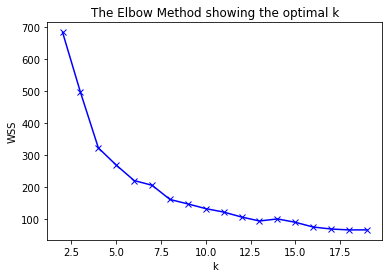

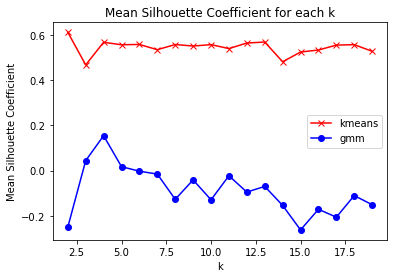

In [91]:
cluster.analyzeK(df)

In [ ]:
trainer = SparkUnsupTrainer()

df_pred = trainer.train(df, KMeans).artifacts['model'].transform(df)

In [ ]:
df_pred.toPandas()

In [ ]:
pdf = df_pred.toPandas()
cluster.plot_cluster(pdf, 'Age', 'rand', 'prediction')

### PCA

In [ ]:
df = df_train.unionByName(df_test).withColumn('rand', f.rand()).withColumn('rand2', f.rand())

processor = SparkPreprocessor({'robust': ['Age', 'rand', 'rand2']}, impute_strategy = 'mean')
df = processor.fit_transform(df)
df.toPandas()

In [ ]:
pca = SparkPCA('features', k = 2)
pca.fit_transform(df).toPandas()

In [ ]:
pca = SparkPCA('features', k = 0.9)
pca.fit_transform(df).toPandas()

### Feature Selection

In [ ]:
df = df_train.unionByName(df_test)
processor = SparkPreprocessor(cat_cols=['Pclass', 'Sex'])
scaler = SparkScaler('Age', 'robust')

df = (
    scaler.fit_transform(processor.fit_transform(df))
    .withColumnRenamed('features', 'cat_features')
    .withColumnRenamed('robust_scaled', 'num_features')
)
df.toPandas()

In [ ]:
selector = SparkFS('num_features', 'cat_features', 'Survived', 'categorical')
selector.transform(df).toPandas()

In [ ]:
selector = SparkFS('num_features', 'cat_features', 'Survived', 'categorical', selectionThreshold=1)
selector.transform(df).select('features').toPandas()

In [ ]:
df = df_train.unionByName(df_test).withColumn('rand', f.rand()).withColumn('rand2', f.rand())
processor = SparkPreprocessor(cat_cols=['Pclass', 'Sex'])
scaler = SparkScaler(['Age', 'rand', 'rand2'], 'robust')

df = (
    scaler.fit_transform(processor.fit_transform(df))
    .withColumnRenamed('features', 'cat_features')
    .withColumnRenamed('robust_scaled', 'num_features')
)

selector = SparkFS('num_features', 'cat_features', 'Survived', 'categorical', 'fpr')
selector.transform(df).select('num_features', 'cat_features', 'selected_continuous', 'selected_categorical', 'features').toPandas()